# 과제: 자전거 대여 수요 예측 경진대회 모델 성능 개선

- [자전거 대여 수요 예측 경진대회 링크](https://www.kaggle.com/c/bike-sharing-demand)

- [모델링 코드 참고 링크](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)

수강생분의 이름과 학번을 입력해주세요.

In [ ]:
print("안희진", "20201944")

안희진 20201944


In [ ]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링

### 이상치 제거

In [ ]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [ ]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생 변수(피처) 추가

In [ ]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

### 필요 없는 피처 제거

In [ ]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [ ]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 평가지표 계산 함수 작성

In [ ]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

# 5. 성능 개선 I : 릿지 회귀 모델

## 5.1 하이퍼 파라미터 최적화(모델 훈련)

### 모델 생성

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 그리드서치 객체 생성

In [ ]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)



# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

### 그리드서치 수행

In [ ]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [ ]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


## 5.2 성능 검증

In [ ]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


# 6. 성능 개선 II : 라쏘 회귀 모델

## 6.1 하이퍼 파라미터 최적화(모델 훈련)

In [ ]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


## 6.2 성능 검증

In [ ]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


# 7. 성능 개선 III : 랜덤 포레스트 회귀 모델

## 7.1 하이퍼 파라미터 최적화(모델 훈련)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


## 7.2 모델 성능 검증

In [ ]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1126


## 7.3 예측 및 결과 제출

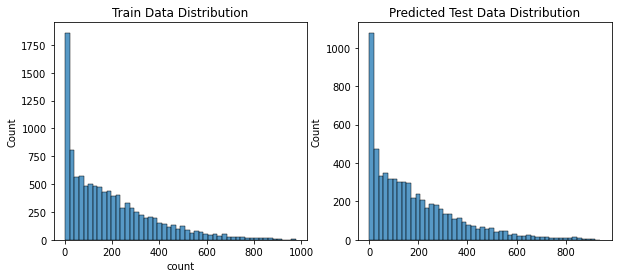

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')

sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [ ]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

# 실습 과제: 개선시도 3가지, 0.39567 보다 낮은 score 달성
아래의 3가지를 모두 개선 시도하여 0.39567 보다 낮은 score를 달성하시오. 과제로 제공한 코드를 기반으로 다른 캐글 코드의 일부 내용을 참고하여 수정하는 것은 허용합니다.

* 1) 피처 엔지니어링
* 2) 모델 선택
* 3) 하이퍼파라미터 최적화

성능 개선 시도한 내용 간략히 작성해주세요.
* 1) 피처 엔지니어링: 수행한 내용 작성
* 2) 모델 선택: 수행한 내용 작성
* 3) 하이퍼파라미터 최적화: 수행한 내용 작성

In [ ]:
#0.39567 보다 낮은 score 달성한 성능 증빙자료는 과제함에 제출해주세요.

In [ ]:
# 1. 피처 엔지니어링 -> 일,분,초 와 같은 피처 생성, 필요없는 피처 삭제(drop)
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

all_data = pd.concat([train, test], ignore_index=True)
all_data

#train['peak'] = train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
#test['peak'] = test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)


# def time_process(df):
#     df['year'] = pd.DatetimeIndex(df.index).year
#     df['month'] = pd.DatetimeIndex(df.index).month
#     df['day'] = pd.DatetimeIndex(df.index).day
#     df['hour'] = pd.DatetimeIndex(df.index).hour
#     df['week'] = pd.DatetimeIndex(df.index).weekofyear
#     df['weekday'] = pd.DatetimeIndex(df.index).dayofweek
#     return df


# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 일 피처 생성
all_data['day'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[2])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 분 피처 생성
all_data['minute'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[1])
# 초 피처 생성
all_data['second'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[2])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())


drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

In [ ]:
# 2.모델 선택 -> GB 사용(다른 모델은 실습에서 사용했고, 나머지 모델 중 가장 많이 사용하는 모델을 선택함) , 3. 하이퍼파라미터 여러가지 실행 결과,최적의 값 찾아서 넣음
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 모델 생성
gb_model = GradientBoostingRegressor()
# 그리드서치 객체 생성
gb_parameters ={'max_depth' : [100,150,500] , 'n_estimators': [3000], 'learning_rate':[0.01, 0.1], 'random_state':[42], 'subsample':[0.07, 0.01]}
gridsearch_gb_model = GridSearchCV(estimator=gb_model,   # GB 모델
                                      param_grid=gb_parameters, # 값 목록
                                      scoring=rmsle_scorer,  # 평가지표
                                      cv=5) 
# 그리드서치 수행
log_y = np.log(y)
gridsearch_gb_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_gb_model.best_params_)

# 예측
preds = gridsearch_gb_model.best_estimator_.predict(X_train)

# 평가
print(f'GB RMSLE 값 : {rmsle(log_y, preds, True):.4f}')


gb_preds = gridsearch_gb_model.best_estimator_.predict(X_test)

submission['count'] = np.exp(gb_preds) # 지수변환
submission.to_csv('submission_final5.csv', index=False)

#max_depth = 3000 -> 11.26
#{'learning_rate': 0.1, 'max_depth': 3000, 'n_estimators': 30, 'random_state': 99, 'subsample': 0.07} -> 0.3003
#n_estimators = 3000 -> 11.18
#n_estimators = 5000 -> 11.18

최적 하이퍼파라미터 : {'learning_rate': 0.01, 'max_depth': 100, 'n_estimators': 3000, 'random_state': 42, 'subsample': 0.01}
GB RMSLE 값 : 0.2745
